In [30]:
% matplotlib inline
# !pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

In [31]:
import os

import cv2
import numpy as np
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from scipy import ndimage
from torch import nn
from torch.optim import Adam

In [32]:
sns.set_theme("notebook", "darkgrid")
np.random.seed(42)
torch.cuda.is_available()

True

In [33]:
root_path = os.path.join(os.path.abspath('..'), "data", "chest_xray")
folders = ('test', 'train', 'val')
img_types = ('NORMAL', 'PNEUMONIA')


def generate_images_list(img_type, sample_size=10):
    images = list()
    for folder in folders:
        path = os.path.join(root_path, folder, img_type)
        images += [os.path.join(path, f) for f in os.listdir(path)]
    images = tuple(images)
    return np.random.choice(images, sample_size, replace=False)

In [34]:
img_sample = 10
images = np.zeros((img_sample, len(img_types)), dtype="U256")
for column, img_type in enumerate(img_types):
    img_list = generate_images_list(img_type, img_sample)
    for row, img in enumerate(img_list):
        images[row, column] = img

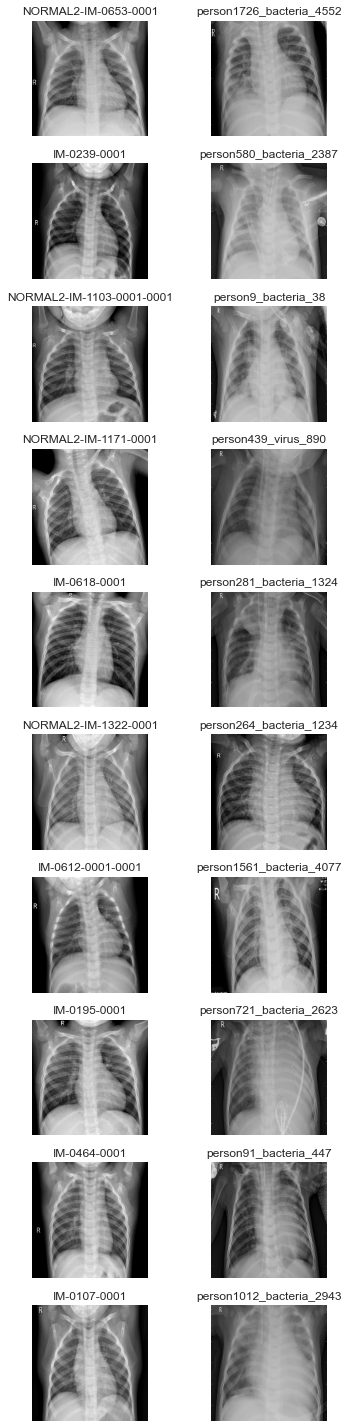

In [35]:
fig: plt.Figure = plt.figure(figsize=(img_sample * 10 / 2, 2 * 10), dpi=72)
for i in range(img_sample):
    for j in range(len(img_types)):
        plot_pos = i * 2 + j + 1
        img = images[i, j]
        ax: plt.Axes = fig.add_subplot(img_sample, 2, plot_pos)
        ax.axis("off")
        img_ar = cv2.imread(img)
        img_ar = cv2.resize(img_ar, (128, 128))
        cv2.cvtColor(img_ar, cv2.COLOR_BGR2GRAY)
        ax.imshow(img_ar, cmap="gray")
        ax.set_title(img.split(".")[0].split("\\")[-1].split("/")[-1])
plt.tight_layout(w_pad=-170)
plt.show()

NameError: name 'x' is not defined

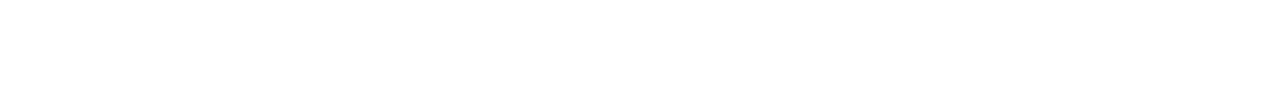

In [44]:
fig: plt.Figure = plt.figure(figsize=(img_sample * 10 / 2, 2 * 10), dpi=72)
for i in range(img_sample):
    for j in range(len(img_types)):
        plot_pos = i * 2 + j + 1
        img = images[i, j]
        ax: plt.Axes = fig.add_subplot(img_sample, 2, plot_pos)
        ax.axis("off")
        img_ar = cv2.imread(img)
        cv2.cvtColor(img_ar, cv2.COLOR_BGR2GRAY)
        img_ar = cv2.resize(img_ar, (128 * 2, 128 * 2))
        img_ar = cv2.GaussianBlur(img_ar, (5, 5), 1, 1)
        if np.random.random() < 0.5:
            img_ar = cv2.flip(img_ar, 1)
        img_ar = ndimage.rotate(img_ar, np.random.randint(-15, 15))
        img_ar = cv2.resize(img_ar, (128, 128))
        # img_ar = img_ar - cv2.bilateralFilter(img_ar,3,90,90)

        # img_ar = cv2.GaussianBlur(img_ar,(21,21),10)
        ax.imshow(img_ar, cmap="gray")
        ax.set_title(img.split(".")[0].split("\\")[-1].split("/")[-1])
plt.tight_layout(w_pad=-170)
plt.show()


In [37]:
class PneumoniaModel(nn.Module):
    def __init__(self, input_shape, dropout=0.1):
        super(PneumoniaModel, self).__init__()
        n_filters = 2
        self.conv1 = nn.Conv2d(1, n_filters, 3, 1)
        self.pool1 = nn.MaxPool2d((3, 3), stride=1)
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = nn.Conv2d(n_filters, n_filters, (3, 3), 1)
        self.pool2 = nn.MaxPool2d((3, 3), stride=1)
        self.dropout2 = nn.Dropout(dropout)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(n_filters * (input_shape[0] - 8) * (input_shape[1] - 8), 32 * 32)
        self.activation1 = nn.LeakyReLU()
        self.dropout3 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(32 * 32, 32 * 32)
        self.activation2 = nn.LeakyReLU()
        self.dropout4 = nn.Dropout(dropout)
        self.linear3 = nn.Linear(32 * 32, 2)
        self.softmax = nn.Softmax(dim=0)

    def forward(self, x, out=0):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        if out == -2:
            return x
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        if out == -1:
            return x
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.dropout3(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.dropout4(x)
        x = self.linear3(x)
        x = self.softmax(x)
        return x

In [53]:
def preprocess(x, resize=128, mode="train"):
    x = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
    x = cv2.resize(x, (256, 256))
    x = cv2.GaussianBlur(x, (5, 5), 1, 1)
    if mode == "train":
        if np.random.random() < 0.5:
            x = cv2.flip(x, 1)
        x = ndimage.rotate(x, np.random.randint(-15, 15))
    x = cv2.resize(x, (resize, resize))
    x = x - (cv2.GaussianBlur(x, (7, 7), 1, 1) * 0.8)
    x = (x - x.mean()).astype(np.float64)
    x = (x / x.max()).astype(np.float64)
    x = x.reshape(resize, resize, 1)
    return x


def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [39]:
path1 = os.path.join(root_path, "train", "NORMAL")
path2 = os.path.join(root_path, "train", "PNEUMONIA")
path3 = os.path.join(root_path, "test", "NORMAL")
path4 = os.path.join(root_path, "test", "PNEUMONIA")
images1 = [preprocess(cv2.imread(os.path.join(path1, f))) for f in os.listdir(path1)]
images1 += [preprocess(cv2.imread(os.path.join(path1, f))) for f in os.listdir(path1)]
images2 = [preprocess(cv2.imread(os.path.join(path2, f))) for f in os.listdir(path2)]
images2 += [preprocess(cv2.imread(os.path.join(path2, f))) for f in os.listdir(path2)]
images3 = [preprocess(cv2.imread(os.path.join(path3, f)), mode="test") for f in os.listdir(path3)]
images4 = [preprocess(cv2.imread(os.path.join(path4, f)), mode="test") for f in os.listdir(path4)]
X_train1 = np.zeros((len(images1), *images1[0].shape))
X_train2 = np.zeros((len(images2), *images2[0].shape))
X_test1 = np.zeros((len(images3), *images3[0].shape))
X_test2 = np.zeros((len(images4), *images4[0].shape))
for i in range(len(images1)):
    X_train1[i] = images1[i]
for i in range(len(images2)):
    X_train2[i] = images2[i]
for i in range(len(images3)):
    X_test1[i] = images3[i]
for i in range(len(images4)):
    X_test2[i] = images4[i]

y_train1 = np.zeros((len(images1), 2))
y_train1[:, 0] = 1.
y_train2 = np.zeros((len(images2), 2))
y_train1[:, 1] = 1.
y_test1 = np.zeros((len(images3), 2))
y_test1[:, 1] = 1.
y_test2 = np.zeros((len(images4), 2))
y_test2[:, 0] = 1.
X_train = np.concatenate((X_train1, X_train2))
y_train = np.concatenate((y_train1, y_train2))
X_test = np.concatenate((X_test1, X_test2))
y_test = np.concatenate((y_test1, y_test2))

X_train, y_train = unison_shuffled_copies(X_train, y_train)
X_test, y_test = unison_shuffled_copies(X_test, y_test)

X_train = torch.tensor(np.moveaxis(X_train, [-1], [1]))
y_train = torch.tensor(y_train)
X_test = torch.tensor(np.moveaxis(X_test, [-1], [1]))
y_test = torch.tensor(y_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

torch.Size([10432, 1, 128, 128]) torch.Size([10432, 2]) torch.Size([624, 1, 128, 128]) torch.Size([624, 2])


In [40]:
def train(model, X, y, criterion, optimizer, batch_size, epochs):
    loss_list = []
    running_loss = 0
    batch_nb = 0
    for i in range(1, epochs + 1):
        last_progress = 0.
        for idx in range(0, X.shape[0], batch_size):
            input_batch = X[idx:idx + batch_size]
            input_batch = input_batch.cuda().float()
            target = y[idx:idx + batch_size]
            target = target.cuda().float()
            optimizer.zero_grad()
            preds = model.forward(input_batch)
            loss = criterion(preds, target)
            loss.backward()
            optimizer.step()
            running_loss += float(loss)
            loss_list.append(float(loss))
            batch_nb += 1

        if (i / epochs) - last_progress > 0.2:
            last_progress = i / epochs
            print(round(i / epochs, 2), round(running_loss / i / X.shape[0], 4))
    return model, loss_list


def test(model, X, y, batch_size):
    correct = 0
    with torch.no_grad():
        for idx in range(0, X.shape[0], batch_size):
            input_batch = X[idx:idx + batch_size]
            input_batch = input_batch.cuda().float()
            target = y[idx:idx + batch_size]
            target = target.cuda().float()
            outputs = model(input_batch)
            correct += (outputs.argmax(1) == target.argmax(1)).sum().item()
    print(f'Test Accuracy of the model on the test images: {(correct / X.shape[0]) :.2%}')


In [41]:
model = PneumoniaModel((128, 128), 0.1)
model.to("cuda")
print(model)


PneumoniaModel(
  (conv1): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=1, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.1, inplace=False)
  (conv2): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(3, 3), stride=1, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.1, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=28800, out_features=1024, bias=True)
  (activation1): LeakyReLU(negative_slope=0.01)
  (dropout3): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=1024, out_features=1024, bias=True)
  (activation2): LeakyReLU(negative_slope=0.01)
  (dropout4): Dropout(p=0.1, inplace=False)
  (linear3): Linear(in_features=1024, out_features=2, bias=True)
  (softmax): Softmax(dim=0)
)


In [43]:
criterion = nn.MSELoss().cuda()
learning_rate = 1e-4
batch_size = 200
epochs = 100
optimizer = Adam(model.parameters(), lr=learning_rate)

model, loss = train(model, X_train, y_train, criterion, optimizer, batch_size, epochs)

0.11 0.0013
0.12 0.0013
0.13 0.0013
0.14 0.0013
0.15 0.0013
0.16 0.0013
0.17 0.0013
0.18 0.0013
0.19 0.0013
0.2 0.0013
0.21 0.0013
0.22 0.0013
0.23 0.0013
0.24 0.0013
0.25 0.0013
0.26 0.0013
0.27 0.0013
0.28 0.0013
0.29 0.0013
0.3 0.0013
0.31 0.0013
0.32 0.0013
0.33 0.0013
0.34 0.0013
0.35 0.0013
0.36 0.0013
0.37 0.0013
0.38 0.0013
0.39 0.0013
0.4 0.0013
0.41 0.0013
0.42 0.0013
0.43 0.0013
0.44 0.0013
0.45 0.0013
0.46 0.0013
0.47 0.0013
0.48 0.0013
0.49 0.0013
0.5 0.0013
0.51 0.0013
0.52 0.0013
0.53 0.0013
0.54 0.0013
0.55 0.0013
0.56 0.0013
0.57 0.0013
0.58 0.0013
0.59 0.0013
0.6 0.0013
0.61 0.0013
0.62 0.0013
0.63 0.0013
0.64 0.0013
0.65 0.0013
0.66 0.0013
0.67 0.0013
0.68 0.0013
0.69 0.0013
0.7 0.0013
0.71 0.0013
0.72 0.0013
0.73 0.0013
0.74 0.0013
0.75 0.0013
0.76 0.0013
0.77 0.0013
0.78 0.0013
0.79 0.0013
0.8 0.0013
0.81 0.0013
0.82 0.0013
0.83 0.0013
0.84 0.0013
0.85 0.0013
0.86 0.0013
0.87 0.0013
0.88 0.0013
0.89 0.0013
0.9 0.0013
0.91 0.0013
0.92 0.0013
0.93 0.0013
0.94 0.0013


In [45]:
print("train")
test(model, X_train, y_train, batch_size)
print("test")
test(model, X_test, y_test, batch_size)

train
Test Accuracy of the model on the test images: 66.77%
test
Test Accuracy of the model on the test images: 69.71%


c:\python\python38-64\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


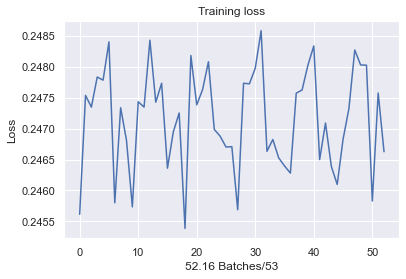

In [46]:
plt.figure()

loss = np.array(loss).reshape(-1, epochs)
loss = loss.mean(axis=1)

sns.lineplot(range(0, len(loss)), loss)
plt.xlabel(f"{len(X_train) / batch_size} Batches/{len(loss)}")
plt.ylabel("Loss")
plt.title("Training loss")
plt.show()
plt.close()

In [47]:
torch.save(model.state_dict(), os.path.join(os.path.abspath("."), "pneumodia_model.pt"))

torch.Size([1, 2, 124, 124])


<ipython-input-111-7cdfdc67b780>:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(2,1,ix+1)


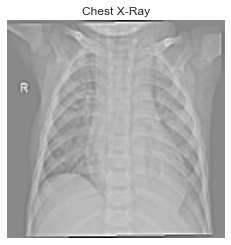

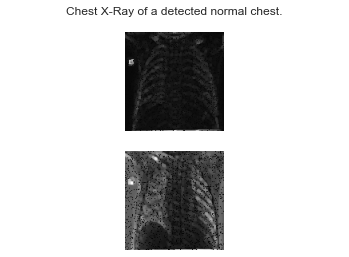

<ipython-input-111-7cdfdc67b780>:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(2,1,ix+1)


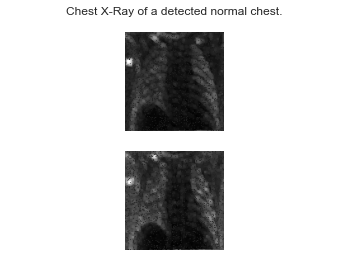

In [111]:
img = [np.moveaxis(preprocess(cv2.imread(f)), -1, 0) for f in generate_images_list("PNEUMONIA", 1)]

plt.figure()
plt.axis("off")
plt.title("Chest X-Ray")
plt.imshow(np.moveaxis(img[0], 0, -1), cmap="gray")

img = torch.tensor(img).float().cuda()
pred = model.forward(img).cpu()
idx = int(pred.argmax(1))
title = f"Chest X-Ray of a detected {img_types[idx].lower()} chest.\n"
    # f"With a confidence level of {float(pred[idx][0]):>5.2%}"
features2 = model.forward(img, -1).detach().cpu()
features1 = model.forward(img, -2).detach().cpu()
print(features1.shape)
sns.set_theme("notebook", "white")
fig = plt.figure()
plt.axis("off")
plt.title(title)

square = 2
for i in range(2):
    ix = 0
    for x in range(square):
        ax = fig.add_subplot(2, 1, ix + 1)
        ax.set_axis_off()
        ax.imshow(features1[0, ix, :, :], cmap='gray')
        ix += 1
plt.show()
fig = plt.figure()
plt.axis("off")
plt.title(title)

square = 2
for i in range(2):
    ix = 0
    for x in range(square):
        ax = fig.add_subplot(2, 1, ix + 1)
        ax.set_axis_off()
        ax.imshow(features2[0, ix, :, :], cmap='gray')
        ix += 1
